In [1]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Loading code from kaggle where sudoku data came from
quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))
#for quiz, solution in zip(quizzes[:10], solutions[:10]):
#    print(quiz)
#    print(solution)

In [10]:
class GenAl(object):
    
    def __init__(self, quiz, pop_size):
        self.sqsubset = self.get_sqsubset()
        self.base = 150 # Use this number of reverse the "error" measure to a "fitness" measure
        self.quizoriginal = quiz 
        self.pop_size = pop_size
        self.population = np.zeros((self.pop_size,9,9)) 
        self.fitness = []
        self.fitness_max = []
        self.fitness_avg = []
        self.solution = 0
        
    ## This is used to subset the array into the 9 smaller squares it is made up of
    def get_sqsubset(self):
        sqsubset = np.zeros((9,9,9))
        sqsubset[0,:3,:3] = 1
        sqsubset[1,:3,3:6] = 1
        sqsubset[2,:3,6:9] = 1
        sqsubset[3,3:6,:3] = 1
        sqsubset[4,3:6,3:6] = 1
        sqsubset[5,3:6,6:9] = 1
        sqsubset[6,6:9,:3] = 1
        sqsubset[7,6:9,3:6] = 1
        sqsubset[8,6:9,6:9] = 1
        return sqsubset==1
    
    ## For the quiz randomly generate filled quizzes and measure their fitness 
    def init_pop(self):
        self.fitness = []
        for i in range(self.pop_size):
            self.population[i] = self.quizoriginal.copy()
            for sub in self.sqsubset:
                s = set(self.population[i][sub].flatten())
                inputs = []
                for j in range(1,10):
                    if j not in s:
                        inputs.append(j)
                inputs = np.array(inputs)
                np.random.shuffle(inputs)
                sset = sub&(self.quizoriginal==0)
                self.population[i][sset] = inputs
            self.fitness.append(self.get_fitness(self.population[i]))
    
    ## Count the number of repeats in rows and columns of quiz to get idea of quiz fitness
    def get_fitness(self, quiz):
        error = 0
        #rows 
        for row in quiz:
            c = Counter(row)
            c = np.array(list(c.values()))
            error += sum(c[c>1])
        #columns
        for col in quiz.T:
            c = Counter(col)
            c = np.array(list(c.values()))
            error += sum(c[c>1])
        return self.base - error
    
    ## Randomly make mutations to a quiz this function will either
        # Do nothing
        # Shuffle one 3x3 grid
        # Swap two numbers in a 3x3 grid
    def mutate(self, quizbaby):
        choice = np.random.randint(0,3,1)[0]
        if choice == 1:
            sset = self.sqsubset[np.random.randint(0,9),:,:]&(self.quizoriginal==0)
            shuf = quizbaby[sset]
            np.random.shuffle(shuf)
            quizbaby[sset] = shuf
        elif choice == 2:
            sset = self.sqsubset[np.random.randint(0,9),:,:]&(self.quizoriginal==0)
            mutatetemp = quizbaby[sset].copy()
            swaps = np.random.randint(0,sset.sum(),2)
            mutatetemp[swaps[0]], mutatetemp[swaps[1]] = mutatetemp[swaps[1]], mutatetemp[swaps[0]]
            quizbaby[sset] = mutatetemp
        return quizbaby.astype(int)
    
    ## swap 3x3 grids of two quizes to form a quiz made up of both 
    def sex(self, quiz1, quiz2):
        order = np.array(range(9))
        np.random.shuffle(order)
        num = round(np.random.normal(4.5))
        baby = np.zeros((9,9))
        baby[self.sqsubset[order[:num],:,:].sum(axis=0)==1] = quiz1[self.sqsubset[order[:num],:,:].sum(axis=0)==1]
        baby[self.sqsubset[order[num:],:,:].sum(axis=0)==1] = quiz2[self.sqsubset[order[num:],:,:].sum(axis=0)==1]
        return baby.astype(int)
        
    ## Takes the current population of quizzes and breeds them 
    ## Fitter quizzes are more likely to be selected
    def breed_pop(self):
        newpopulation = np.zeros((self.pop_size, 9, 9))
        insertindex = 0
        newfitness = []
        to_breed = 0
        babies = 0
        while babies < self.pop_size:
            to_try = np.random.randint(0,self.pop_size)
            if self.fitness[to_try] > np.random.randint(min(self.fitness),max(self.fitness)):
                if to_breed == 0:
                    thing_to_breed = self.population[to_try]
                    to_breed = 1
                else:
                    newpopulation[insertindex,:,:] = self.mutate(self.sex(thing_to_breed, self.population[to_try]))
                    newfitness.append(self.get_fitness(newpopulation[insertindex,:,:]))
                    to_breed = 0
                    insertindex += 1
                    babies += 1
        self.population, self.fitness = newpopulation.astype(int), newfitness
    
    ## Run the breed pop in a loop until the solution is found or reaches max
    def run(self, times = 100):
        self.init_pop()
        self.fitness_max.append(min(self.fitness)) 
        self.fitness_avg.append(np.mean(self.fitness))
        for i in range(times):
            self.fitness_max.append(max(self.fitness)) 
            self.fitness_avg.append(np.mean(self.fitness))
            self.breed_pop()
            if max(self.fitness) == self.base:
                print("We have our perfect baby!")
                self.solution = self.population[np.array(self.fitness) == max(self.fitness)]
                break

In [11]:
# Take 2nd quiz and a population size of 100 and setting 1,000 and the maximum number of generations
GA = GenAl(quizzes[1].copy(), 100)
GA.run(10000)

We have our perfect baby!


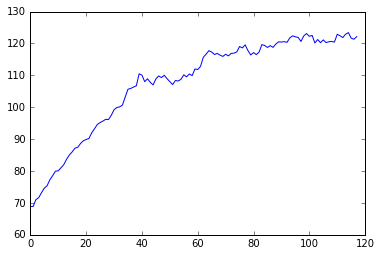

In [12]:
# The average fitness of each successive generation
plt.plot(GA.fitness_avg)

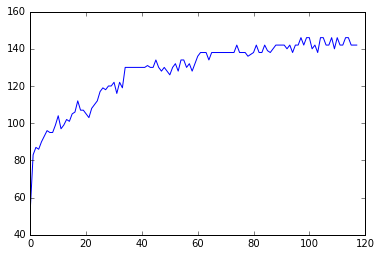

In [13]:
# The maximum fitness of each successive generation
plt.plot(GA.fitness_max)

In [14]:
# Checking the solution is in fact the same solution
GA.solution==solutions[1]

array([[[ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True]]], dtype=bool)

In [ ]:
#need to do some sort of grid search 

## Things to do grid search over 
# population size 
# amount of mutations 
# how elitist selection is